In [1]:
import pandas as pd 
import numpy as np
from tensorflow.keras.preprocessing.image import * 
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import random
import os 

In [2]:
path = "C:\\Users\jesung\\github\\CodingLife\\20220316\\"

# 데이터 형상 관련 상수 정의 
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNEL=3

# 학습 데이터 준비 
filenames = os.listdir(path+"train")

categories=[]
for filename in filenames:
    category=filename.split(".")[0]
    if category =="dog":
        categories.append(1)
    else:
        categories.append(0)
df=pd.DataFrame(
    {"filename":filenames,
    "category":categories}
)        
df

,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0
...,...,...
24995,dog.9995.jpg,1
24996,dog.9996.jpg,1
24997,dog.9997.jpg,1
24998,dog.9998.jpg,1


<AxesSubplot:>

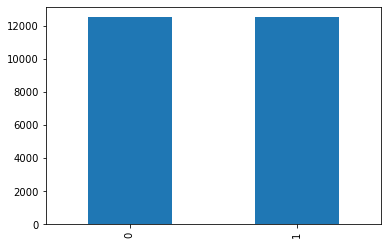

In [3]:
df['category'].value_counts().plot.bar()

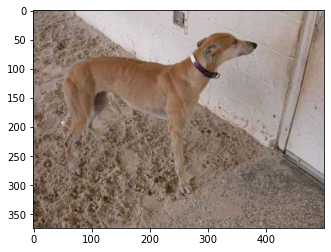

In [4]:
sample = random.choice(filenames)
image = load_img(path+"train\\"+sample)
plt.imshow(image)

# 모델 생성

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import * 

In [6]:
# 레이어 1
model = Sequential()
model.add(Conv2D(32, (3,3), activation="relu", input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH , IMAGE_CHANNEL)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 레이어 2 
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 레이어3
model.add(Conv2D(128, (3,3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
          
# Fully Connected 
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(2,activation="softmax"))

In [7]:
model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)       2

In [8]:
# reduceLROnPlateau  모델의 정확도가 향상되지 않는 경우 ㅡ learning rate (lr) 을 줄여주는 클래스
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience=10)
learning_rate_reduction=ReduceLROnPlateau(
                        monitor= "val_accuracy", 
                        patience = 2, 
                        factor = 0.5, 
                        min_lr=0.0001,
                        verbose=1)
                        
callbacks = [earlystop, learning_rate_reduction]

In [9]:
# 이미지 제너레이터에서 class_mode = "categorical"로 지정하기 위해 컬럼 카테고리를 스트링으로 변경함. 
df['category']=df['category'].replace({0:'cat',1:"dog"})

# test, train 데이터 분리

In [10]:
train_df, validate_df = train_test_split(df , test_size=0.2, random_state= 42)

train_df=train_df.reset_index(drop=True)
validate_df=validate_df.reset_index(drop=True)

# training data의 generator 생성

In [11]:
total_train=train_df.shape[0]
total_validate=validate_df.shape[0]
batch_size=15

# 트레이닝 데이터의 제너레이터 설정 
train_datagen=ImageDataGenerator(
        rotation_range=15,
        rescale=1./255,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        width_shift_range=0.1, 
        height_shift_range=0.1)
        
train_generator=train_datagen.flow_from_dataframe(
    train_df, 
    path+"train",
    x_col = "filename", 
    y_col = "category",
    target_size = IMAGE_SIZE,
    class_mode = "categorical",
    batch_size = batch_size )
    
validate_datagen=ImageDataGenerator(rescale=1./255)
# 검증이미지니까, 사진 그대로 쓰겠다. 

validation_generator=validate_datagen.flow_from_dataframe(
    validate_df,
    path+"train",
    x_col= "filename",
    y_col= "category",
    target_size = IMAGE_SIZE,
    class_mode = "categorical",
    batch_size = batch_size )

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


# sample data 확인

In [12]:
example_df=train_df.sample(n=1).reset_index(drop=True)
example_df

,filename,category
0,dog.11061.jpg,dog


In [13]:
example_generator = train_datagen.flow_from_dataframe(
                    example_df,
                    path+"train",
                    x_col = "filename",
                    y_col = "category",
                    target_size = IMAGE_SIZE,
                    class_mode = "categorical")

Found 1 validated image filenames belonging to 1 classes.


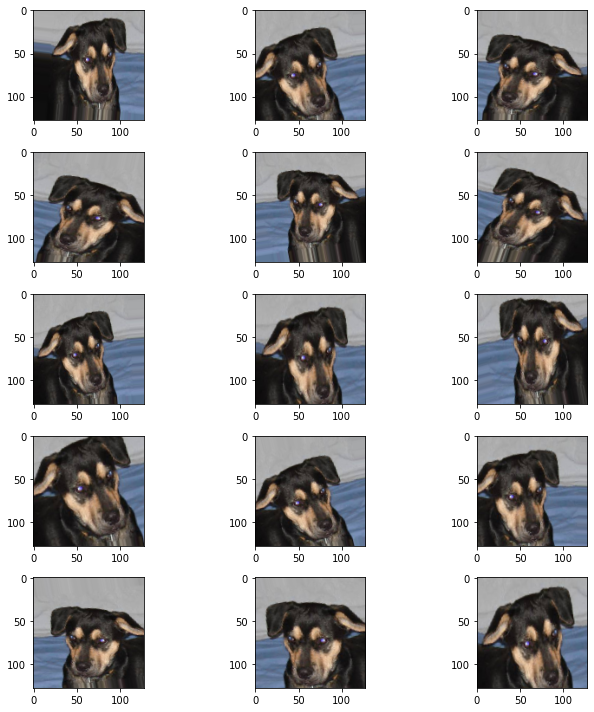

In [14]:
plt.figure(figsize=(10,10))
for i in range(0,15):
    plt.subplot(5,3,i+1)
    for xBatch, yBatch in example_generator:
        image = xBatch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# Training

In [15]:
epochs = 3 

history = model.fit_generator(
    train_generator, 
    epochs = epochs, 
    steps_per_epoch = total_train//batch_size ,
    validation_data=  validation_generator,
    validation_steps = total_validate//batch_size,
    callbacks = callbacks,
)

# 모델 저장 
model.save_weights("model.h5")

C:\Users\jesung\AppData\Local\Temp/ipykernel_11876/1863558134.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/3
1333/1333 [==============================] - 176s 130ms/step - loss: 0.7426 - accuracy: 0.6399 - val_loss: 0.5429 - val_accuracy: 0.7327 - lr: 0.0010
Epoch 2/3
1333/1333 [==============================] - 99s 74ms/step - loss: 0.5512 - accuracy: 0.7281 - val_loss: 0.5303 - val_accuracy: 0.7536 - lr: 0.0010
Epoch 3/3
1333/1333 [==============================] - 104s 78ms/step - loss: 0.4968 - accuracy: 0.7624 - val_loss: 0.4400 - val_accuracy: 0.7986 - lr: 0.0010


In [16]:
historyDict = history.history

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

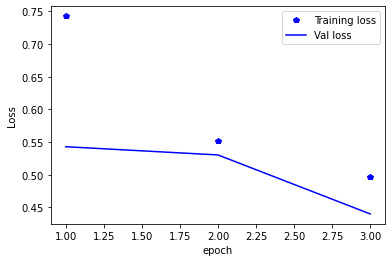

In [17]:
epo = range(1, len(acc)+1)
plt.plot(epo, loss, 'bp', label="Training loss")
plt.plot(epo, val_loss, 'b', label="Val loss")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

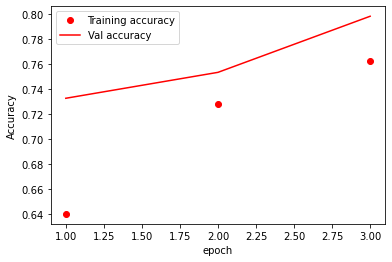

In [18]:
plt.plot(epo, acc, 'ro', label="Training accuracy")
plt.plot(epo, val_acc, 'r', label="Val accuracy")
plt.xlabel("epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# 테스트

In [26]:
# 테스트 데이터 준비 
filenames = os.listdir(path+"test1")

test_df=pd.DataFrame( {"filename":filenames} )      
test_df

,filename
0,1.jpg
1,10.jpg
2,100.jpg
3,1000.jpg
4,10000.jpg
...,...
12495,9995.jpg
12496,9996.jpg
12497,9997.jpg
12498,9998.jpg


In [27]:
nbsamples=test_df.shape[0]

In [28]:
test_datagen=ImageDataGenerator(rescale=1./255)
# 테스트 이미지니까, 사진 그대로 씀
test_generator=test_datagen.flow_from_dataframe(
    test_df,
    path+"test1",
    x_col= "filename",
    y_col= None,
    target_size = IMAGE_SIZE,
    class_mode = None,
    batch_size = batch_size,
    shuffle = False)

Found 12500 validated image filenames.


In [29]:
# 3. 예측 
predict=model.predict_generator(test_generator, 
                                steps=nbsamples/batch_size, 
                                callbacks=callbacks)
                                
test_df['category']=np.argmax(predict, axis=1)

C:\Users\jesung\AppData\Local\Temp/ipykernel_11876/2795810202.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict=model.predict_generator(test_generator,


# 테스트 샘플 랜덤으로 추출해서 확인

In [30]:
test_df['category']=test_df['category'].replace({0:'cat', 1:"dog"})
ex_df=test_df.sample(n=1).reset_index(drop=True)
ex_df

,filename,category
0,1058.jpg,cat


In [31]:
ex_generator = test_datagen.flow_from_dataframe(
    ex_df,
    path+"test1",
    x_col = "filename",
    y_col = None,
    target_size = IMAGE_SIZE,
    class_mode = None)

Found 1 validated image filenames.


In [32]:
test_sample = list(ex_df.filename)

sample = ""
for test in test_sample:
    sample += test

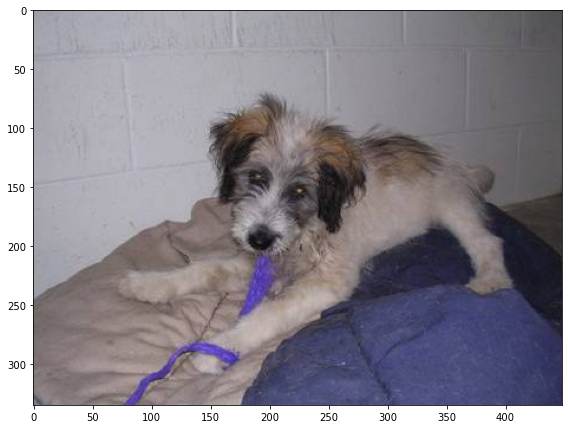

In [34]:
image = load_img(path+"test1\\"+sample)
plt.figure(figsize=(8,8))
plt.imshow(image)

plt.tight_layout()
plt.show()

# 제출할 양식에 맞게 수정

In [38]:
sampleSubmission=pd.read_csv(path+"Submission.csv", dtype="object")
sampleSubmission

index=[]
for filename in test_df.filename:
    li=filename.split(".")[0]
    index.append(li)
    
test_df["id"]=index

final=test_df.merge(sampleSubmission)[['id','category']]
final['id']=final['id'].astype("int64")
final=final.sort_values("id")

final.rename({'category':"label"},axis='columns').to_csv("Submission.csv", index=False)

In [39]:
test_df

,filename,category,id
0,1.jpg,dog,1
1,10.jpg,cat,10
2,100.jpg,dog,100
3,1000.jpg,dog,1000
4,10000.jpg,dog,10000
...,...,...,...
12495,9995.jpg,cat,9995
12496,9996.jpg,dog,9996
12497,9997.jpg,dog,9997
12498,9998.jpg,cat,9998
